In [1]:
%matplotlib inline
from typing import Union
import pandas as pd
import matplotlib.pyplot as plt
import re

In [8]:
def extract_metro(m: str) -> str:
    return m.split(' (')[0].replace('м. ', '')

def extract_minutes(m: str) -> Union[int, None]:
    match = re.search(r'[0-9]{1,2}', m)
    if match is None:
        return None
    return int(match.group(0))

def extract_by_foot(m: str) -> bool:
    match = re.search(r'пешком', m)
    if match is None:
        return False
    return True

df = pd.read_excel('../../data/offers_filtered.xlsx', index_col='ID')
df['metro'] = df['Метро'].apply(extract_metro)
df['m_to_metro'] = df['Метро'].apply(extract_minutes)
df['by_foot'] = df['Метро'].apply(extract_by_foot)

In [9]:
def extract_area(index: int):
    def extract(m: str) -> float:
        split = m.split('/')
        return float(split[index])

    return extract

df['total_area'] = df['Площадь, м2'].apply(extract_area(0))
df['living_area'] = df['Площадь, м2'].apply(extract_area(1))
df['kitchen_area'] = df['Площадь, м2'].apply(extract_area(2))

In [10]:
df = df.dropna(subset=['Ремонт'])

df['is_cosmetic'] = df['Ремонт'].apply(lambda x: x.strip() == 'Косметический')

In [11]:
def extract_floor(index: int):
    def extract(m: str) -> int:
        match = re.sub(r'((?![0-9/]).)*', '', m)
        return int(match.split('/')[index])

    return extract

df['floor'] = df['Дом'].apply(extract_floor(0))
df['max_floor'] = df['Дом'].apply(extract_floor(1))

In [12]:
def extract_price(index: int):
    def extract(m: str) -> float:
        matches = re.findall(r"[0-9]+", m, re.MULTILINE)
        matches = [match for match in matches if float(match) > 1]
        if len(matches) < index + 1:
            return float(matches[0])
        return float(matches[index])

    return extract

df['price'] = df['Цена'].apply(extract_price(0))

In [13]:
result = df[['metro', 'm_to_metro', 'by_foot', 'total_area', 'living_area', 'kitchen_area', 'is_cosmetic', 'floor', 'max_floor', 'price']]

In [14]:
result = result.where(result['by_foot'] > 0).dropna()
filtered = result.where(result['is_cosmetic'] > 0).dropna()

In [15]:
len(filtered)

25

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

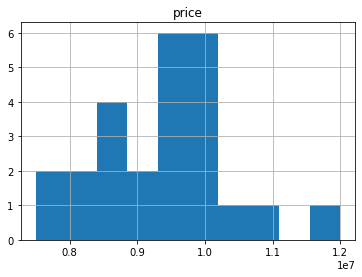

In [16]:
filtered.hist(column='price')


In [19]:
final_df = filtered[['metro', 'm_to_metro', 'total_area', 'living_area', 'kitchen_area', 'is_cosmetic', 'floor', 'max_floor', 'price']]
final_df.to_excel('../../data/sale/sale.xlsx')